In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3

conn = sqlite3.connect("f1_data.db")



In [79]:
df = pd.read_sql("""
        SELECT *
        FROM tyre_changes
    """, conn)

In [ ]:
df[np.abs(df["lap_time_change"]) > 1000]

In [67]:
df[df['session_key'] == 9173]

,driver,change_type,tyre_change_lap,laps_on_old_tyre,laps_on_new_tyre,pos_before,pos_after,position_change,lap_time_change,session_key,position_change_z,change_label
504,1.0,MEDIUM->MEDIUM,16.0,16.0,5.0,1.0,2.50,1.50,-2.25325,9173,-0.501877,MM
505,1.0,MEDIUM->HARD,37.0,21.0,5.0,1.0,1.00,0.00,-3.84750,9173,-1.009088,MH
506,2.0,MEDIUM->MEDIUM,2.0,2.0,3.0,16.5,19.25,2.75,-38.07675,9173,-0.079201,MM
507,2.0,MEDIUM->MEDIUM,5.0,3.0,5.0,19.0,19.25,0.25,-30.14925,9173,-0.924553,MM
508,2.0,MEDIUM->HARD,21.0,16.0,1.0,18.0,17.00,-1.00,NaN,9173,-1.347229,MH
509,4.0,MEDIUM->HARD,17.0,17.0,5.0,2.0,4.25,2.25,-2.81700,9173,-0.248271,MH
510,4.0,HARD->HARD,36.0,19.0,5.0,2.0,2.75,0.75,-3.22175,9173,-0.755482,HH
511,10.0,MEDIUM->HARD,18.0,18.0,5.0,7.5,13.25,5.75,-2.93650,9173,0.935222,MH
512,10.0,HARD->HARD,34.0,16.0,5.0,8.0,10.25,2.25,-3.22500,9173,-0.248271,HH
513,11.0,MEDIUM->HARD,2.0,2.0,5.0,7.0,17.50,10.50,-47.50825,9173,2.541391,MH


## 1. Does weather affect how many tyre changes there are in a race?

In [ ]:
weather = pd.read_sql("""
        SELECT *
        FROM weather
    """, conn)
sessions_weather = weather.groupby("session_key")[["wind_speed", "rainfall", "track_temperature", "air_temperature", "humidity", "pressure"]].mean()

In [ ]:
changes_per_race = df.groupby("session_key").size().rename("n_tyre_changes")
race_level = sessions_weather.merge(changes_per_race, on="session_key", how="inner")

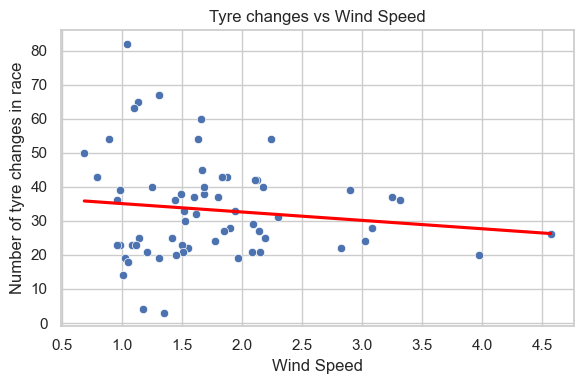

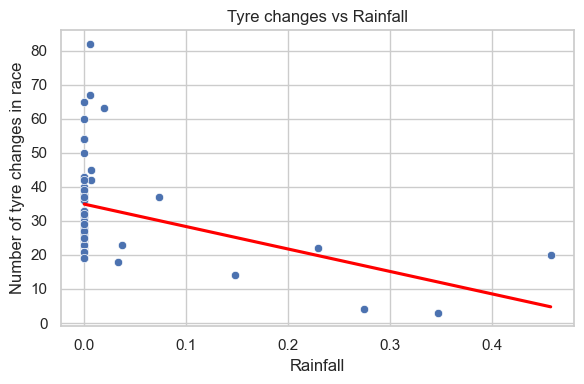

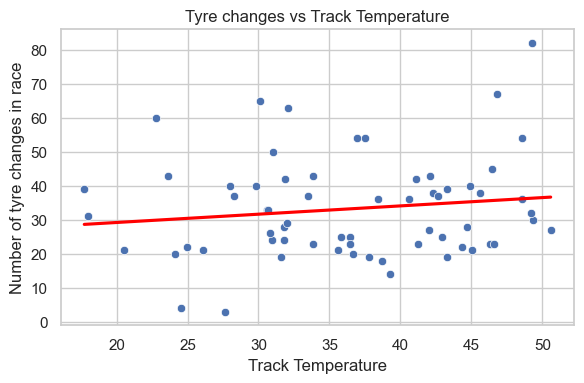

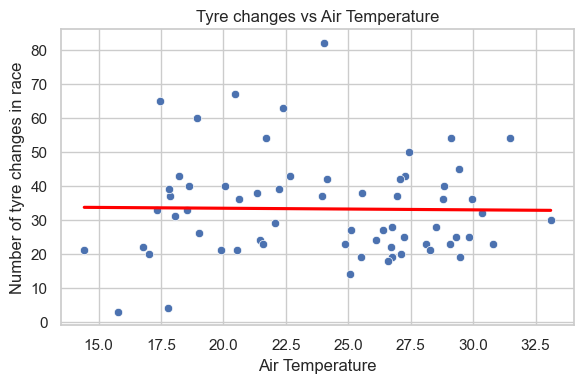

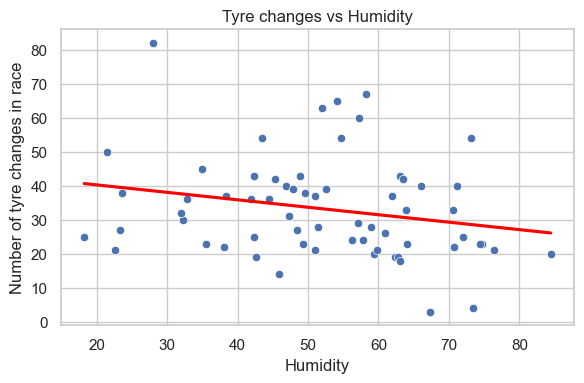

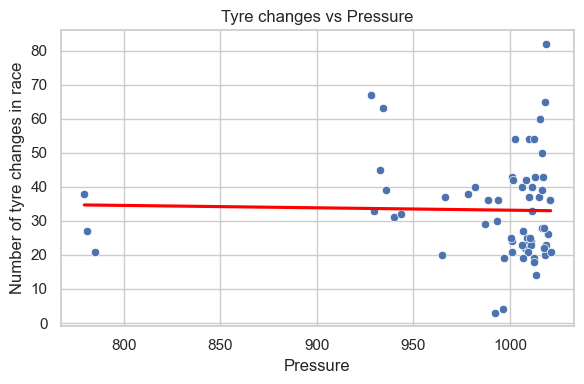

In [25]:
weather_vars = ["wind_speed", "rainfall", "track_temperature",
                "air_temperature", "humidity", "pressure"]

sns.set(style="whitegrid", context="notebook")

for col in weather_vars:
    plt.figure(figsize=(6,4))
    sns.scatterplot(data=race_level, x=col, y="n_tyre_changes")
    sns.regplot(data=race_level, x=col, y="n_tyre_changes",
                scatter=False, color="red", ci=None)
    plt.title(f"Tyre changes vs {col.replace('_',' ').title()}")
    plt.xlabel(col.replace('_',' ').title())
    plt.ylabel("Number of tyre changes in race")
    plt.tight_layout()
    plt.show()


## 2. Tyre change type vs. position change

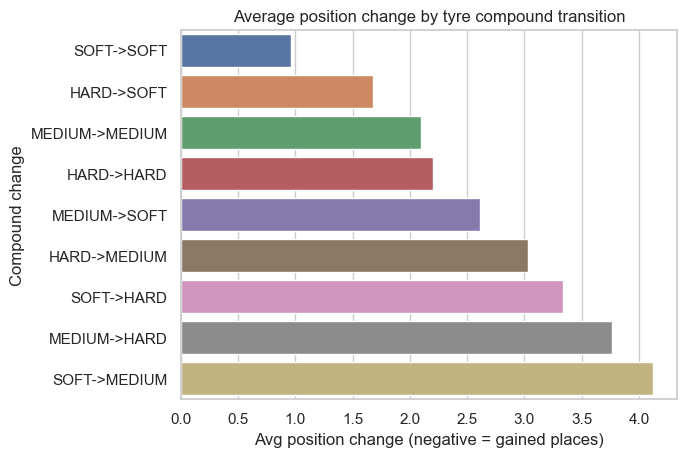

In [26]:
type_summary = (
    df.groupby("change_type")["position_change"]
      .agg(['mean','std','count'])
      .sort_values("mean")
)
sns.barplot(y=type_summary.index, x=type_summary["mean"])
plt.title("Average position change by tyre compound transition")
plt.xlabel("Avg position change (negative = gained places)")
plt.ylabel("Compound change")
plt.show()

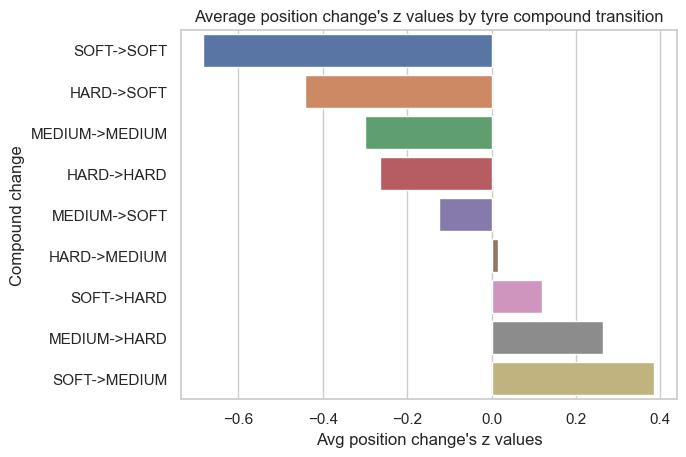

In [38]:
import numpy as np
df["position_change_z"] = df["position_change"].apply(lambda x: (x-np.mean(df["position_change"]))/np.std(df["position_change"]))
type_summary_z = (
    df.groupby("change_type")["position_change_z"]
      .agg(['mean','std','count'])
      .sort_values("mean")
)
sns.barplot(y=type_summary_z.index, x=type_summary_z["mean"])
plt.title("Average position change's z values by tyre compound transition")
plt.xlabel("Avg position change's z values")
plt.ylabel("Compound change")
plt.show()

## 3. When do each type of tyre change happen

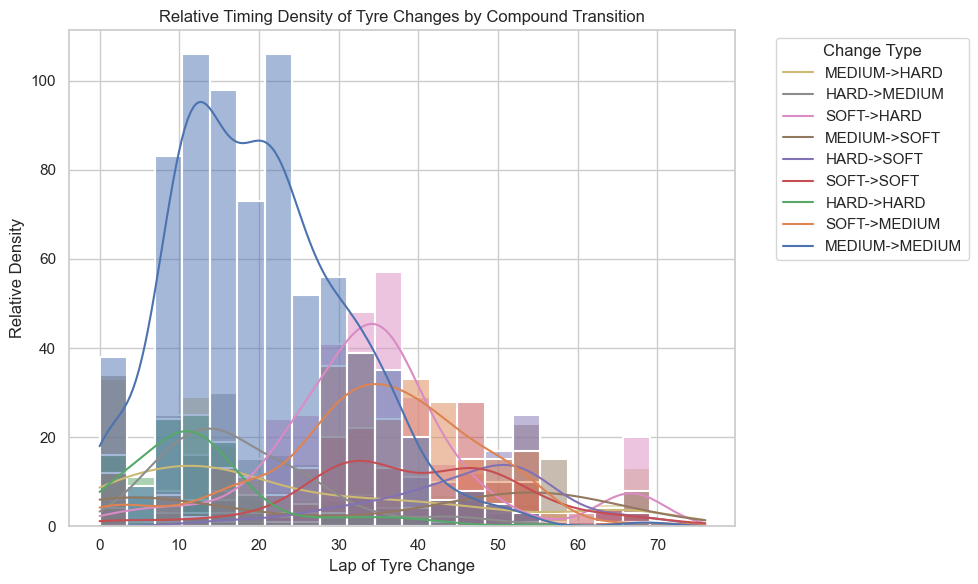

In [93]:
plt.figure(figsize=(10,6))
sns.histplot(
    data=df,
    x="tyre_change_lap",
    hue="change_type",
    fill=True,
    common_norm=False,
    alpha=0.5,
    linewidth=1.5,
    kde = True,
)
plt.title("Relative Timing Density of Tyre Changes by Compound Transition")
plt.xlabel("Lap of Tyre Change")
plt.ylabel("Relative Density")
plt.legend(title="Change Type", labels=df["change_type"].unique(), bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


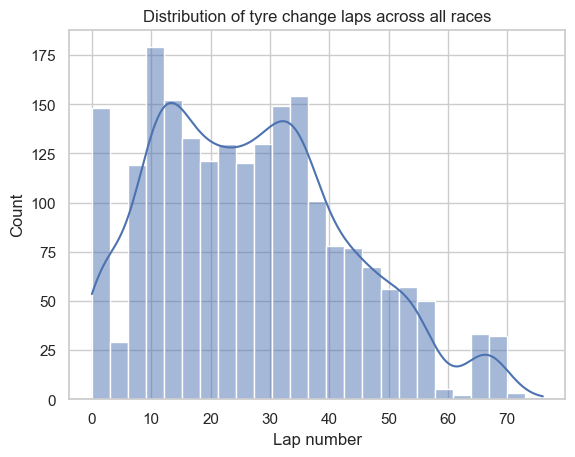

In [91]:
sns.histplot(df["tyre_change_lap"], bins=25, kde=True)
plt.title("Distribution of tyre change laps across all races")
plt.xlabel("Lap number")
plt.ylabel("Count")
plt.show()


## 4. How the type of tyre change affect positions and lapse time

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 [Text(0, 0, 'SM'),
  Text(1, 0, 'MH'),
  Text(2, 0, 'HS'),
  Text(3, 0, 'SH'),
  Text(4, 0, 'MS'),
  Text(5, 0, 'HS'),
  Text(6, 0, 'SS'),
  Text(7, 0, 'MM'),
  Text(8, 0, 'HH')])

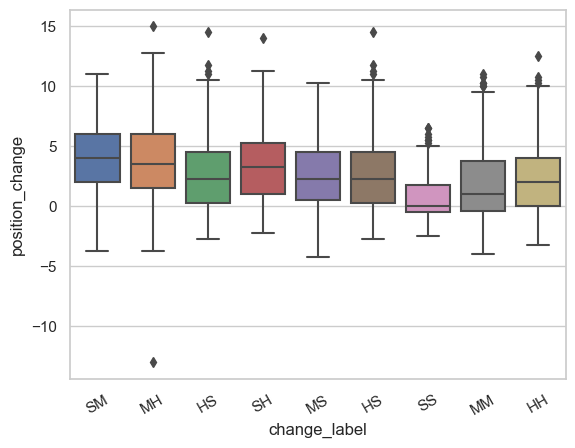

In [80]:
df["change_label"] = df["change_type"].map(label_map)
label_map = {
    "SOFT->MEDIUM": "SM",
    "MEDIUM->HARD": "MH",
    "HARD->SOFT": "HS",
    "SOFT->HARD": "SH",
    "MEDIUM->SOFT": "MS",
    "HARD->MEDIUM": "HS",
    "SOFT->SOFT": "SS",
    "MEDIUM->MEDIUM": "MM",
    "HARD->HARD": "HH",
}
sns.boxplot(data=df,
    x="change_label",
    y="position_change",
    order=[label_map[k] for k in label_map],

    )
plt.xticks(rotation=30)


(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 [Text(0, 0, 'SM'),
  Text(1, 0, 'MH'),
  Text(2, 0, 'HS'),
  Text(3, 0, 'SH'),
  Text(4, 0, 'MS'),
  Text(5, 0, 'HS'),
  Text(6, 0, 'SS'),
  Text(7, 0, 'MM'),
  Text(8, 0, 'HH')])

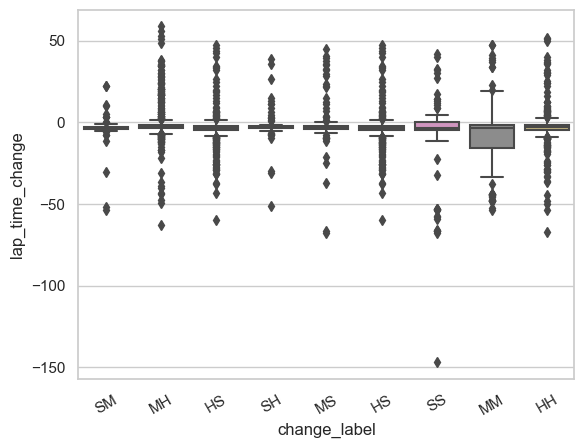

In [81]:
clean_df = df[np.abs(df["lap_time_change"]) < 200]
sns.boxplot(data=clean_df.dropna(),
    x="change_label",
    y="lap_time_change",
    order=[label_map[k] for k in label_map],

    )
plt.xticks(rotation=30)

## 5. What type of tyre change caused unusally long laps? (What type of tyre change induces more risks)

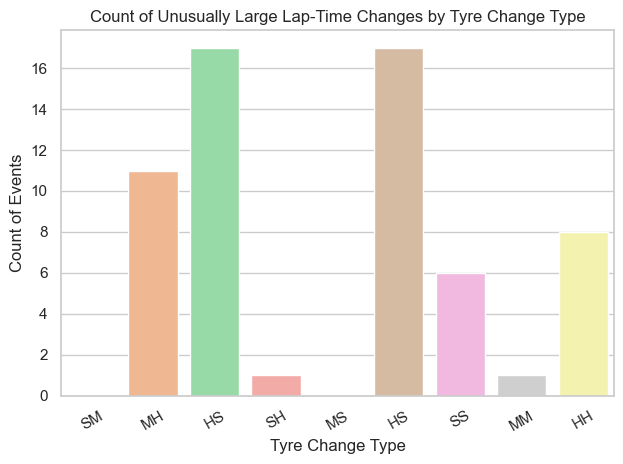

In [87]:
long_df = df[np.abs(df["lap_time_change"]) >= 200]
sns.countplot(
    data=long_df.dropna(),
    x="change_label",
    order=[label_map[k] for k in label_map],
    palette="pastel"
)
plt.xticks(rotation=30)
plt.xlabel("Tyre Change Type")
plt.ylabel("Count of Events")
plt.title("Count of Unusually Large Lap-Time Changes by Tyre Change Type")
plt.tight_layout()
plt.show()

## 6. How Tyre changes in different stage of a race affect positions

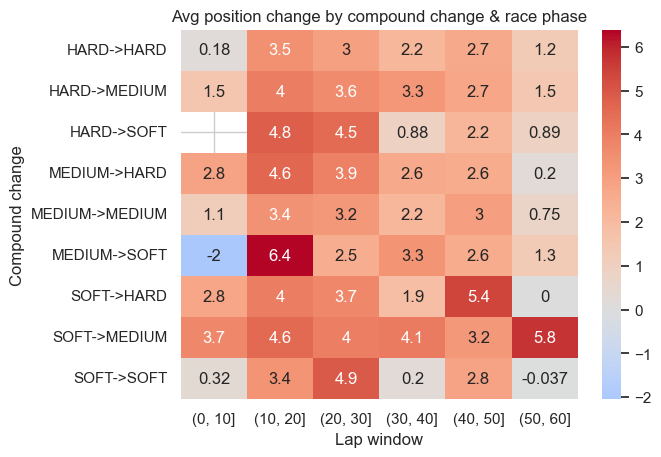

In [94]:
heatmap_data = (
    df.pivot_table(values="position_change",
                   index="change_type",
                   columns=pd.cut(df["tyre_change_lap"], bins=[0,10,20,30,40,50,60]),
                   aggfunc="mean")
)
sns.heatmap(heatmap_data, annot=True, cmap="coolwarm", center=0)
plt.title("Avg position change by compound change & race phase")
plt.xlabel("Lap window")
plt.ylabel("Compound change")
plt.show()


## 7. Regression on position change using type of tyre change

In [104]:
import statsmodels.formula.api as smf

model = smf.ols(
    "position_change ~ C(change_type) + laps_on_old_tyre + lap_time_change + tyre_change_lap",
    data=df
).fit()

print(model.summary().tables[0])
print(model.summary().tables[1])


                            OLS Regression Results                            
Dep. Variable:        position_change   R-squared:                       0.154
Model:                            OLS   Adj. R-squared:                  0.149
Method:                 Least Squares   F-statistic:                     32.72
Date:                Sun, 16 Nov 2025   Prob (F-statistic):           1.99e-64
Time:                        01:16:46   Log-Likelihood:                -4790.0
No. Observations:                1995   AIC:                             9604.
Df Residuals:                    1983   BIC:                             9671.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercep